<a href="https://colab.research.google.com/github/tamzid958/machine-learning/blob/master/Classification_of_Alzheimers_95_TOTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
import fastai
import torch.nn as nn
from fastai.callbacks.hooks import *

In [ ]:
PATH = Path('/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/')

torch.Size([3, 208, 176])


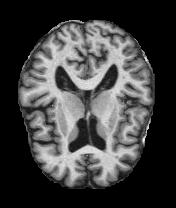

In [ ]:
img = open_image(Path(PATH, 'train/VeryMildDemented/verymildDem972.jpg'))
print(img.shape)
img

In [ ]:
transform = get_transforms(max_rotate=7.5,
                           max_zoom=1.15,
                           max_lighting=0.15,
                           max_warp=0.15,
                           p_affine=0.8, p_lighting = 0.8, 
                           xtra_tfms= [
                               pad(mode='zeros'),
                               symmetric_warp(magnitude=(-0.1,0.1)),
                               cutout(n_holes=(1,3), length=(5,5))
                           ])

In [ ]:
data = ImageDataBunch.from_folder(PATH, train="train/",
                                  test="test/",
                                  valid_pct=.4,
                                  ds_tfms=transform,
                                  size=112,bs=64, 
                                  ).normalize(imagenet_stats)

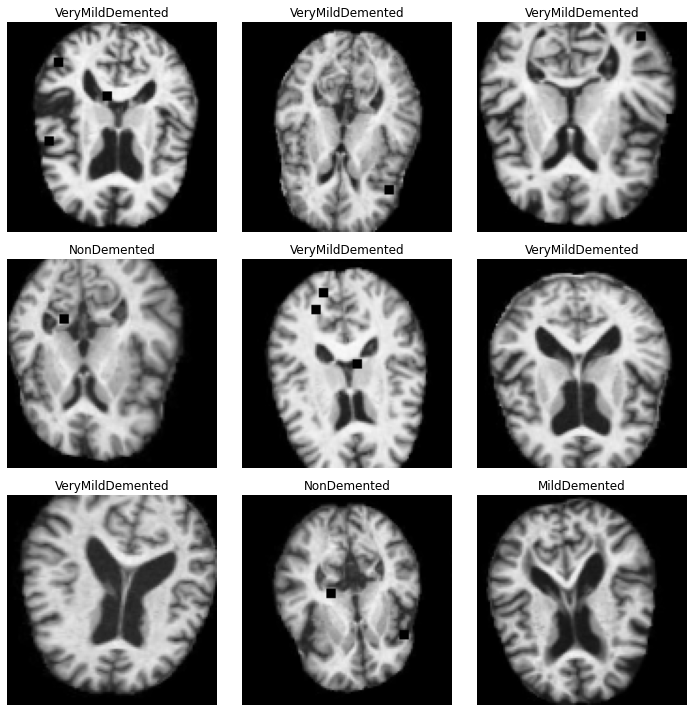

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
Category.__eq__ = lambda self, that: self.data == that.data
Category.__hash__ = lambda self: hash(self.obj)
Counter(data.train_ds.y)

Counter({Category 0: 427, Category 1: 30, Category 2: 1543, Category 3: 1073})

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.871823,1.228073,0.544765,0.547852,20:43
1,1.496292,0.959205,0.569961,0.581543,20:10


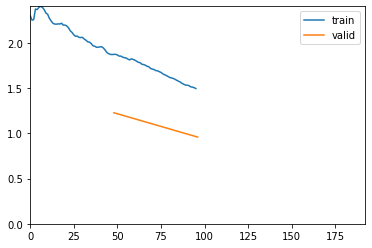

In [ ]:
learn = cnn_learner(data, models.vgg16_bn, metrics=[FBeta(average='weighted'),accuracy], wd=1e-1, callback_fns=ShowGraph)
learn.fit_one_cycle(4)

In [ ]:
Model_Path = Path(PATH,'Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.save('checkpoint-1')

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.946437,0.851899,0.590640,0.601074,00:25
1,0.927341,0.812331,0.621031,0.626465,00:25
2,0.890610,0.788793,0.631012,0.639160,00:25
3,0.866801,0.782988,0.635891,0.644043,00:25


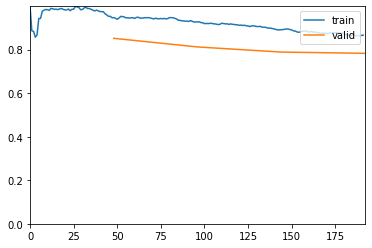

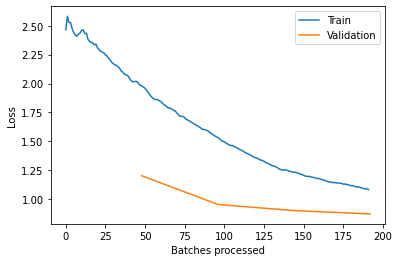

In [ ]:
learn.model
learn.recorder.plot_losses()
learn.load('checkpoint-1')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-4))

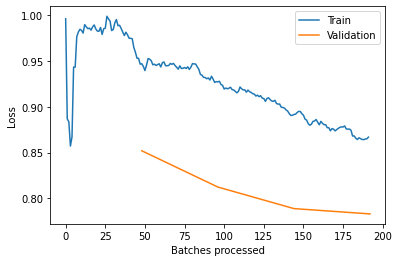

In [ ]:
learn.model
learn.recorder.plot_losses()
learn.save('checkpoint-2')

In [ ]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [ ]:
transform = get_transforms(max_rotate=7.5,
                           max_zoom=1.15,
                           max_lighting=0.15,
                           max_warp=0.15,
                           p_affine=0.8,
                           p_lighting = 0.8,
                           xtra_tfms= [
                               pad(mode='zeros'),
                               symmetric_warp(magnitude=(-0.1,0.1)),
                               cutout(n_holes=(1,6),length=(5,20))])

In [ ]:
data = ImageDataBunch.from_folder(PATH, train="train/",
                                  test="test/",
                                  valid_pct=.2,
                                  ds_tfms=transform,
                                  size=224,bs=32, 
                                  ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.vgg16_bn, pretrained=False, metrics=[error_rate, FBeta(average='weighted')], wd=1e-1, callback_fns=ShowGraph)
Model_Path = Path(PATH,'Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.load('checkpoint-2')

Learner(data=ImageDataBunch;

Train: LabelList (4097 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented,ModerateDemented
Path: /content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset;

Valid: LabelList (1024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NonDemented,MildDemented,VeryMildDemented,NonDemented,MildDemented
Path: /content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset;

Test: LabelList (1279 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

epoch,train_loss,valid_loss,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


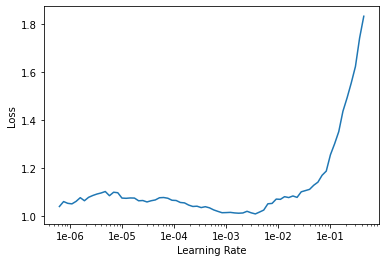

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.934523,0.831920,0.376953,0.599147,01:14
1,0.836256,0.938384,0.389648,0.571233,01:15
2,0.765627,0.652633,0.303711,0.686232,01:15
3,0.668698,0.648069,0.283203,0.715305,01:15
4,0.596506,0.844959,0.315430,0.659810,01:16
5,0.525524,0.631229,0.264648,0.730151,01:15
6,0.445244,0.452867,0.184570,0.813610,01:15
7,0.368351,2.052063,0.439453,0.497890,01:15
8,0.281044,0.809105,0.279297,0.708414,01:15
9,0.230614,0.550202,0.178711,0.812951,01:16


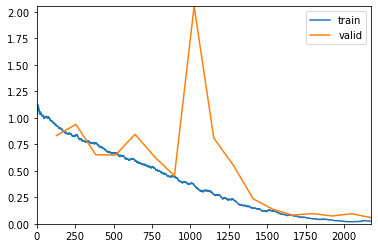

In [ ]:
learn.fit_one_cycle(17, max_lr=5e-4)

In [ ]:
learn.save('checkpoint-3')


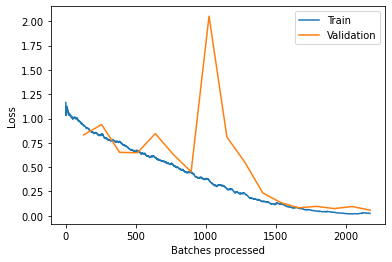

In [ ]:
learn.model
learn.recorder.plot_losses()

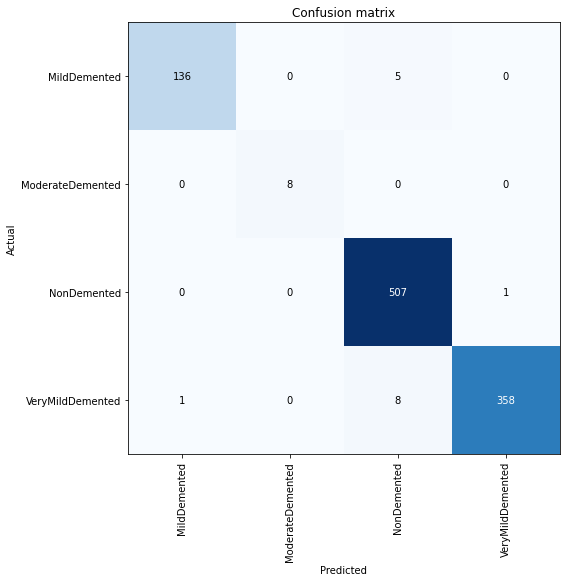

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
transform = get_transforms()

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
random_seed(42, True)

In [ ]:
data_test =  ImageDataBunch.from_folder(PATH,
                                        #ignore_empty=True,
                                  train="test/",#"train/",
                                  valid="test/",
                                  valid_pct=.95,
#                                  ds_tfms=transform,
                                  size=224,bs=32,
                                  num_workers=0
                                  ).normalize(imagenet_stats)
ev = learn.validate(data_test.train_dl,metrics=[error_rate, FBeta(average='weighted')])
print('Results from test set \tError rate:', float(ev[1]), '\tF Beta Score: ', float(ev[2]))

Results from test set 	Error rate: 0.05000000074505806 	F Beta Score:  0.9494270086288452


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


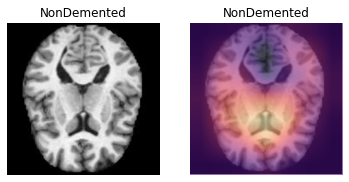

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


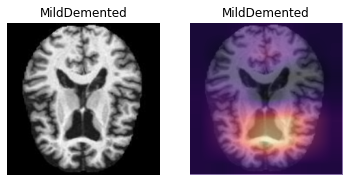

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


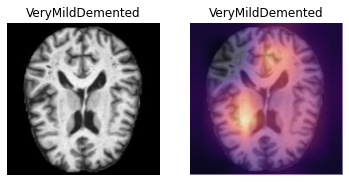

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


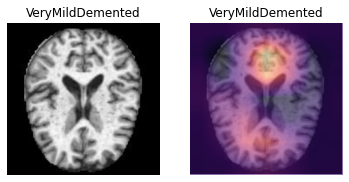

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


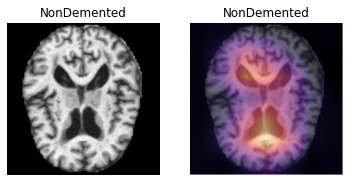

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


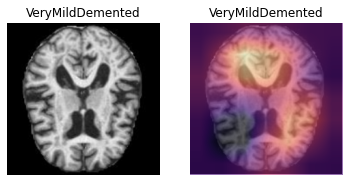

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


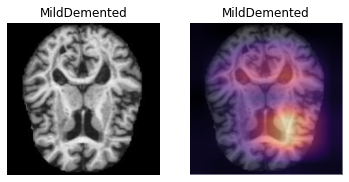

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


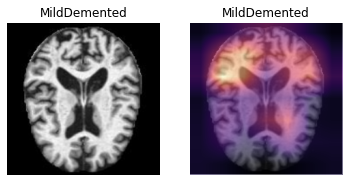

In [ ]:
def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(label)
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))


idx_list = [0,1,2,31,3,63, 142, 207]        
#idx_list = range(200,220)
for idx in idx_list:# range(10):
    visualize_cnn_by_cam(learn, idx)